# ML approach for neutrino selection

This notebook demonstrates an overview of the current status of the neural network study.

#### Importing packages (some of them are, in fact, not used)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import os, re, gc, shutil, time
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import skimage.transform
# from tqdm import tqdm

#os.environ["CUDA_VISIBLE_DEVICES"] = '1'
# from cnn_utils import *

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Concatenate, Add
#from tensorflow.keras import optimizers, metrics, losses
import tensorflow.keras.optimizers, tensorflow.keras.metrics, tensorflow.keras.losses
from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.utils import HDF5Matrix, to_categorical

import tensorflow.keras.backend as K
from tensorflow.keras.utils import get_custom_objects
K.set_image_data_format('channels_last')
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

2023-07-25 16:39:38.523936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Wall coordinates

Geometrical configurations for the wall selection and for the hit 2D visualisations (in matplotlib)

In [2]:
wall_coords = [0, 300.+1, 313.+1, 326.+1, 339.+1, 352.+3]
# event_map_w = event_map * (event_meta[:,0]>wall_coords[i_wall]) * (event_meta[:,0]<wall_coords[i_wall+1])

In [3]:
imextent = {
    'scifi_h':(0, 5, 15, 54),
    'scifi_v':(0, 5, -46, -7),
    'us_h':(0, 5, 12, 66),
    'us_v':(0, 5, 4, -79),
    'ds_h':(0, 4, 7, 71),
    'ds_v':(0, 4, 2, -79),
}

## Data formation

In [4]:
path = '/mnt/ML-drive/Artem/SND/data/neutrino_ml/MC_explore/neutrino/sndlhc_13TeV_down_volTarget_100fb-1_SNDG18_02a_01_000/'
with h5py.File(path+'data.h5', 'r') as df:
    for n in df.keys():
        if n=='ids' or n=='label': continue
        print(n, df[n].shape)

ds (317702, 4, 60, 2)
event_metadata (317702, 3)
scifi (317702, 5, 1536, 2)
us (317702, 5, 10, 2)


In [5]:
## KEYS OF METADATA
## event_meta[i_event] = (event.MCTrack[0].GetStartZ(), event.MCTrack[0].GetPdgCode(), event.MCTrack[1].GetPdgCode())
with h5py.File(path+'data.h5', 'r') as df:
    metadata = df['event_metadata'][...]
map_ve = (np.abs(metadata[:,1])==12) * (np.abs(metadata[:,2])!=12)
map_nc = (np.abs(metadata[:,1])==np.abs(metadata[:,2])) * ((np.abs(metadata[:,1])!=12))
map_vm_cc = (np.abs(metadata[:,1])==14) * (np.abs(metadata[:,2])!=14)

In [6]:
print('ve:', np.sum(map_ve))
print('nc:', np.sum(map_nc))
print('vm_cc:', np.sum(map_vm_cc))

ve: 55671
nc: 59727
vm_cc: 181107


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
def which_wall(pos, wall_coords):
    for i in range(5):
        if (pos>wall_coords[i]) and (pos<wall_coords[i+1]):
            return i
    return -1

In [9]:
ids_ve = np.arange(metadata.shape[0])[map_ve]
ids_nc = np.arange(metadata.shape[0])[map_nc]
ids_vm_cc = np.arange(metadata.shape[0])[map_vm_cc]

all_ids = np.concatenate((ids_ve, ids_vm_cc, ids_nc))
all_labels = np.concatenate((np.ones_like(ids_ve)*0, np.ones_like(ids_vm_cc)*1, np.ones_like(ids_nc)*2))
all_walls = np.array([which_wall(metadata[id_ev, 0], wall_coords) for id_ev in all_ids])
if np.any(all_walls<0): print(all_ids[all_walls<0], '\n', metadata[all_ids[all_walls<0], 0], '\n', metadata[all_ids[all_walls<0], 1])
    

# test_size = 0.2
# tr_ids, test_ids, tr_lab, test_lab = train_test_split(all_ids, all_labels, test_size=test_size, shuffle=True)
# print('train:')
# print(np.unique(tr_lab, return_counts=True))
# print('test:')
# print(np.unique(test_lab, return_counts=True))

# with h5py.File(path+'data.h5', 'a') as df:
#     df.create_dataset('ids/train', data=tr_ids)
#     df.create_dataset('ids/test', data=test_ids)
#     df.create_dataset('label/train', data=tr_lab)
#     df.create_dataset('label/test', data=test_lab)

with h5py.File(path+'data.h5', 'r') as df:
    tr_ids = df['ids/train'][...]
    test_ids = df['ids/test'][...]
    tr_lab = df['label/train'][...]
    test_lab = df['label/test'][...]

In [10]:
tr_sort = np.argsort(tr_ids)
tr_ids = tr_ids[tr_sort].astype(int)
tr_lab = tr_lab[tr_sort]
tr_walls = np.array([which_wall(metadata[id_ev, 0], wall_coords) for id_ev in tr_ids])
if np.any(tr_walls<0):
    print(tr_ids[tr_walls<0], '\n', metadata[tr_ids[tr_walls<0], 0], '\n', metadata[tr_ids[tr_walls<0], 1])
    raise ValueError("event outside scifi walls")

test_sort = np.argsort(test_ids)
test_ids = test_ids[test_sort].astype(int)
test_lab = test_lab[test_sort]
test_walls = np.array([which_wall(metadata[id_ev, 0], wall_coords) for id_ev in test_ids])
if np.any(test_walls<0): 
    print(test_ids[test_walls<0], '\n', metadata[test_ids[test_walls<0], 0], '\n', metadata[test_ids[test_walls<0], 1])
    raise ValueError("event outside scifi walls")

In [11]:
det_names = ['scifi', 'us', 'ds']
x_tr = {}
x_test = {}
with h5py.File(path+'data.h5', 'r') as df:
    for name in det_names:
        tmp_data = df[name][...]
        print(name, tmp_data[tr_ids].shape)
        if name=='scifi':
            x_tr['scifi_h'] = (tmp_data[tr_ids, :, :, 0].copy())[..., np.newaxis]
            x_tr['scifi_v'] = (tmp_data[tr_ids, :, :, 1].copy())[..., np.newaxis]
            print('tr scifi_h: ', x_tr['scifi_h'].shape)
            print('tr scifi_v: ', x_tr['scifi_v'].shape)
            x_test['scifi_h'] = (tmp_data[test_ids, :, :, 0].copy())[..., np.newaxis]
            x_test['scifi_v'] = (tmp_data[test_ids, :, :, 1].copy())[..., np.newaxis]
            print('tr scifi_h: ', x_test['scifi_h'].shape)
            print('tr scifi_v: ', x_test['scifi_v'].shape)
            # x_test[name] = tmp_data[test_ids].copy()
            # print('test '+name+': ', x_test[name].shape)
        else:
            x_tr[name] = tmp_data[tr_ids].copy()
            print('tr '+name+': ', x_tr[name].shape)
            x_test[name] = tmp_data[test_ids].copy()
            print('test '+name+': ', x_test[name].shape)
gc.collect();

scifi (251525, 5, 1536, 2)
tr scifi_h:  (251525, 5, 1536, 1)
tr scifi_v:  (251525, 5, 1536, 1)
tr scifi_h:  (62882, 5, 1536, 1)
tr scifi_v:  (62882, 5, 1536, 1)
us (251525, 5, 10, 2)
tr us:  (251525, 5, 10, 2)
test us:  (62882, 5, 10, 2)
ds (251525, 4, 60, 2)
tr ds:  (251525, 4, 60, 2)
test ds:  (62882, 4, 60, 2)


## Toy model definition

### Full model

In [12]:
n_cl = 3
n_wall = 5
scifi_shape=(5,1536,1)
us_shape=(5,10,2)
ds_shape=(4,60,2)
drop_middle_scifi = 0.5
drop_middle_us = 0.5
drop_middle_ds = 0.5

lr=2e-4 #; betaa1=30; betaa2=100; decay=1e-3

### SciFi
scifi_h_input = Input(scifi_shape, name='scifi_h_in')
X_scifi_h = Conv2D(16, kernel_size=(3,4), padding='same', activation='elu', name='scifi_h_conv1_1')(scifi_h_input)
X_scifi_h = Conv2D(16, kernel_size=(3,4), padding='same', activation='elu', name='scifi_h_conv1_2')(X_scifi_h)
X_scifi_h = MaxPooling2D(pool_size=(1,4), padding='valid', name='scifi_h_pool1')(X_scifi_h)

X_scifi_h = Conv2D(32, kernel_size=(3,4), padding='same', activation='elu', name='scifi_h_conv2_1')(X_scifi_h)
X_scifi_h = MaxPooling2D(pool_size=(1,4), padding='valid', name='scifi_h_pool2')(X_scifi_h)

X_scifi_h = Dropout(rate=drop_middle_scifi, name='scifi_h_drop_middle')(X_scifi_h)

X_scifi_h = Conv2D(32, kernel_size=(3,4), padding='same', activation='elu', name='scifi_h_conv3_1')(X_scifi_h)
X_scifi_h = MaxPooling2D(pool_size=(1,2), padding='valid', name='scifi_h_pool3')(X_scifi_h)

X_scifi_h = Conv2D(64, kernel_size=(3,3), padding='same', activation='elu', name='scifi_h_conv4_1')(X_scifi_h)
X_scifi_h = Conv2D(64, kernel_size=(3,3), padding='same', activation='elu', name='scifi_h_conv4_2')(X_scifi_h)
X_scifi_h = MaxPooling2D(pool_size=(2,2), padding='same', name='scifi_h_pool4')(X_scifi_h)
X_scifi_h = Flatten()(X_scifi_h)

### SciFi
scifi_v_input = Input(scifi_shape, name='scifi_v_in')
X_scifi_v = Conv2D(16, kernel_size=(3,4), padding='same', activation='elu', name='scifi_v_conv1_1')(scifi_v_input)
X_scifi_v = Conv2D(16, kernel_size=(3,4), padding='same', activation='elu', name='scifi_v_conv1_2')(X_scifi_v)
X_scifi_v = MaxPooling2D(pool_size=(1,4), padding='valid', name='scifi_v_pool1')(X_scifi_v)

X_scifi_v = Conv2D(32, kernel_size=(3,4), padding='same', activation='elu', name='scifi_v_conv2_1')(X_scifi_v)
X_scifi_v = MaxPooling2D(pool_size=(1,4), padding='valid', name='scifi_v_pool2')(X_scifi_v)

X_scifi_v = Dropout(rate=drop_middle_scifi, name='scifi_v_drop_middle')(X_scifi_v)

X_scifi_v = Conv2D(32, kernel_size=(3,4), padding='same', activation='elu', name='scifi_v_conv3_1')(X_scifi_v)
X_scifi_v = MaxPooling2D(pool_size=(1,2), padding='valid', name='scifi_v_pool3')(X_scifi_v)

X_scifi_v = Conv2D(64, kernel_size=(3,3), padding='same', activation='elu', name='scifi_v_conv4_1')(X_scifi_v)
X_scifi_v = Conv2D(64, kernel_size=(3,3), padding='same', activation='elu', name='scifi_v_conv4_2')(X_scifi_v)
X_scifi_v = MaxPooling2D(pool_size=(2,2), padding='same', name='scifi_v_pool4')(X_scifi_v)
X_scifi_v = Flatten()(X_scifi_v)


### US
us_input = Input(us_shape, name='us_in')
X_us = Conv2D(16, kernel_size=(3,3), padding='same', activation='elu', name='us_conv1_1')(us_input)
X_us = Conv2D(32, kernel_size=(3,3), padding='same', activation='elu', name='us_conv1_2')(X_us)
X_us = MaxPooling2D(pool_size=2, padding='same', name='us_pool1')(X_us)

X_us = Conv2D(32, kernel_size=(3,3), padding='same', activation='elu', name='us_conv2_1')(X_us)
X_us = MaxPooling2D(pool_size=2, padding='same', name='us_pool2')(X_us)

X_us = Dropout(rate=drop_middle_us, name='us_drop_middle')(X_us)

X_us = Conv2D(64, kernel_size=(3,3), padding='same', activation='elu', name='us_conv3_1')(X_us)
X_us = Flatten()(X_us)

### DS
ds_input = Input(ds_shape, name='ds_in')
X_ds = Conv2D(16, kernel_size=(3,3), padding='same', activation='elu', name='ds_conv1_1')(ds_input)
X_ds = Conv2D(32, kernel_size=(3,3), padding='same', activation='elu', name='ds_conv1_2')(X_ds)
X_ds = MaxPooling2D(pool_size=(1,2), padding='same', name='ds_pool1')(X_ds)

X_ds = Conv2D(32, kernel_size=(3,3), padding='same', activation='elu', name='ds_conv2_1')(X_ds)
X_ds = MaxPooling2D(pool_size=2, padding='same', name='ds_pool2')(X_ds)

X_ds = Dropout(rate=drop_middle_ds, name='ds_drop_middle')(X_ds)

X_ds = Conv2D(64, kernel_size=(3,3), padding='same', activation='elu', name='ds_conv3_1')(X_ds)
X_ds = Flatten()(X_ds)



X = Concatenate()([X_scifi_h, X_scifi_v, X_us, X_ds])
X_cl = Dense(n_cl, activation='softmax', name='y_class')(X)
X_wall = Dense(n_wall, activation='softmax', name='y_wall')(X)

toy_model = Model(inputs = [scifi_h_input, scifi_v_input, us_input, ds_input], outputs = [X_cl, X_wall], name='full_toy_model')

K.clear_session()

adamka = tf.keras.optimizers.Adam(learning_rate=lr)

toy_model.compile(optimizer=adamka, loss={'y_class':'categorical_crossentropy', 'y_wall':'categorical_crossentropy'}, metrics={'y_class':'categorical_accuracy', 'y_wall':'categorical_accuracy'})

2023-07-25 16:40:48.495136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-25 16:40:48.495910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-25 16:40:49.024154: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-25 16:40:49.024845: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-25 16:40:49.025372: I tensorflow/compiler/xla/stream_executo

In [13]:
toy_model.summary()

Model: "full_toy_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 scifi_h_in (InputLayer)        [(None, 5, 1536, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 scifi_v_in (InputLayer)        [(None, 5, 1536, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 scifi_h_conv1_1 (Conv2D)       (None, 5, 1536, 16)  208         ['scifi_h_in[0][0]']             
                                                                                     

## Train model

In [14]:
hist = toy_model.fit(x=[x_tr['scifi_h'], x_tr['scifi_v'], x_tr['us'], x_tr['ds']], y=[to_categorical(tr_lab, num_classes=n_cl), to_categorical(tr_walls, num_classes=n_wall)], batch_size=128, epochs=25)

2023-07-25 16:40:55.441259: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1931712000 exceeds 10% of free system memory.
2023-07-25 16:40:57.019970: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1931712000 exceeds 10% of free system memory.
2023-07-25 16:40:58.805683: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1931712000 exceeds 10% of free system memory.
2023-07-25 16:40:59.763884: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1931712000 exceeds 10% of free system memory.


Epoch 1/25


2023-07-25 16:41:03.691064: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infull_toy_model/scifi_h_drop_middle/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-07-25 16:41:09.431324: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-07-25 16:41:17.281288: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x559d773f1440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-25 16:41:17.281370: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-07-25 16:41:17.281407: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-07-25 16:41:17.725116: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] di

1966/1966 [==============================] - 214s 96ms/step - loss: 0.8205 - y_class_loss: 0.5547 - y_wall_loss: 0.2659 - y_class_categorical_accuracy: 0.7734 - y_wall_categorical_accuracy: 0.9114
Epoch 2/25
1966/1966 [==============================] - 198s 101ms/step - loss: 0.6823 - y_class_loss: 0.4799 - y_wall_loss: 0.2024 - y_class_categorical_accuracy: 0.8019 - y_wall_categorical_accuracy: 0.9355
Epoch 3/25
1966/1966 [==============================] - 198s 101ms/step - loss: 0.6464 - y_class_loss: 0.4655 - y_wall_loss: 0.1808 - y_class_categorical_accuracy: 0.8076 - y_wall_categorical_accuracy: 0.9432
Epoch 4/25
1966/1966 [==============================] - 198s 101ms/step - loss: 0.6147 - y_class_loss: 0.4555 - y_wall_loss: 0.1592 - y_class_categorical_accuracy: 0.8119 - y_wall_categorical_accuracy: 0.9495
Epoch 5/25
1966/1966 [==============================] - 199s 101ms/step - loss: 0.5936 - y_class_loss: 0.4477 - y_wall_loss: 0.1459 - y_class_categorical_accuracy: 0.8155 - y_w

In [15]:
toy_model.save('toy_neutrino_25')

INFO:tensorflow:Assets written to: toy_neutrino_25/assets


INFO:tensorflow:Assets written to: toy_neutrino_25/assets


In [16]:
retoy_model = tf.keras.models.load_model("toy_neutrino_25")

In [17]:
test_pred = toy_model.predict(x=[x_test['scifi_h'], x_test['scifi_v'], x_test['us'], x_test['ds']])

1966/1966 [==============================] - 15s 7ms/step


In [22]:
np.savetxt('test_pred_class.txt', test_pred[0], delimiter=', ', header='predictions: ve, vm, nc')
np.savetxt('test_pred_walls.txt', test_pred[1], delimiter=', ', header='predictions: walls 0-4')

## Confusion matrix

In [18]:
## Total in row = 100%
def confusion_matrix(y_true, y_pred):
    n_class = len(np.unique(y_true))
    conf_mat = np.zeros((n_class, n_class))
    n_tot = len(y_true)
    for i in range(n_class):
        for j in range(n_class):
            conf_mat[i, j] = np.sum((y_true==i)*(y_pred==j))/np.sum((y_true==i))*100
    return np.around(conf_mat, decimals=1)

* sum over every row is 100%

In [19]:
confusion_matrix(test_lab, np.argmax(test_pred[0], axis=-1))

array([[71.4,  5.6, 23. ],
       [ 4.5, 90.5,  5. ],
       [27.7,  8.3, 64. ]])

In [20]:
## Total in column = 100%
def confusion_purity_matrix(y_true, y_pred):
    n_class = len(np.unique(y_true))
    conf_mat = np.zeros((n_class, n_class))
    n_tot = len(y_true)
    for i in range(n_class):
        for j in range(n_class):
            conf_mat[i, j] = np.sum((y_true==i)*(y_pred==j))/np.sum((y_pred==j))*100
    return np.around(conf_mat, decimals=1)

* sum over every column is 100%

In [21]:
confusion_purity_matrix(test_lab, np.argmax(test_pred[0], axis=-1))

array([[67.9,  2.4, 26.3],
       [10.6, 94.8, 14.1],
       [21.5,  2.8, 59.5]])

## Study events

In [24]:
nchan = {'scifi':1536, 'us':10, 'ds':60}
nplane = {'scifi':5, 'us':5, 'ds':4}

#### CORRECT PREDICTIONS

In [30]:
## CORRECT PREDICTIONS
y_test_pred = np.argmax(test_pred[0], axis=-1)
y_test_wall = np.argmax(test_pred[1], axis=-1)

class_names = ['ve', 'vm', 'nc']
hit_wall = {}
for det_name in ['scifi_h', 'scifi_v', 'us', 'ds']:
    hit_wall[det_name] = {}
    for i_wall in range(5):
        hit_wall[det_name][i_wall] = {}
        for i_cl, cl_name in enumerate(class_names):
            hit_mask = ((test_lab==i_cl) * (y_test_pred==i_cl) * (test_walls==i_wall)).astype(bool)            
            hit_wall[det_name][i_wall][cl_name] = x_test[det_name][hit_mask]


### Event examples

n= 19


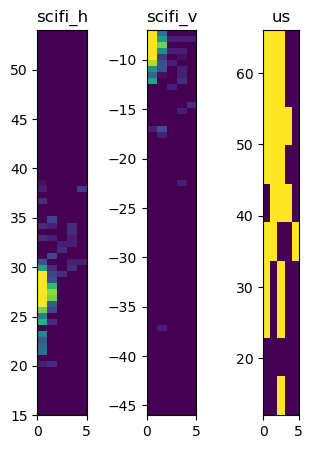

In [31]:
# n = np.random.randint(1000)
n = 19
print('n=',n)
fig, ax = plt.subplots(1, 3, figsize=(4,5))

hit_scifi = np.zeros((nplane['scifi'], 64, 2), dtype=int)
tmp_scifi = hit_wall['scifi_h'][0]['ve'][n,...,0]
for i in range(64): #12
    hit_scifi[:, i, 0] = tmp_scifi[:, 24*i:24*(i+1)].sum(axis=1) #128
tmp_scifi = hit_wall['scifi_v'][0]['ve'][n,...,0]
for i in range(64):
    hit_scifi[:, i, 1] = tmp_scifi[:, 24*i:24*(i+1)].sum(axis=1)
plt.imshow(hit_scifi[...,0].T)
for i, name in enumerate(['scifi_h', 'scifi_v', 'us']):
    if 'scifi' in name:
        ax[i].imshow(hit_scifi[...,i].T, origin='lower', extent=imextent[name])
    else:
        ax[i].imshow(hit_wall['us'][0]['ve'][n,...,0].T, extent=imextent['us_h'])
    ax[i].set_title(name)
    # cbar = fig.colorbar(im, ax=ax[i])
plt.show()

n= 19


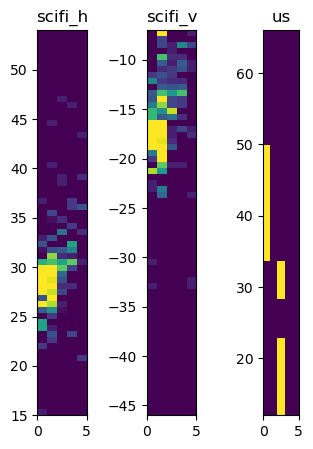

In [325]:
# n = np.random.randint(1000)
n = 19
print('n=',n)
fig, ax = plt.subplots(1, 3, figsize=(4,5))

hit_scifi = np.zeros((nplane['scifi'], 64, 2), dtype=int)
tmp_scifi = hit_wall['scifi_h'][0]['ve'][n,...,0]
for i in range(64): #12
    hit_scifi[:, i, 0] = tmp_scifi[:, 24*i:24*(i+1)].sum(axis=1) #128
tmp_scifi = hit_wall['scifi_v'][0]['ve'][n,...,0]
for i in range(64):
    hit_scifi[:, i, 1] = tmp_scifi[:, 24*i:24*(i+1)].sum(axis=1)
plt.imshow(hit_scifi[...,0].T)
for i, name in enumerate(['scifi_h', 'scifi_v', 'us']):
    if 'scifi' in name:
        ax[i].imshow(hit_scifi[...,i].T, origin='lower', extent=imextent[name])
    else:
        ax[i].imshow(hit_wall['us'][0]['ve'][n,...,0].T, extent=imextent['us_h'])
    ax[i].set_title(name)
    # cbar = fig.colorbar(im, ax=ax[i])
plt.show()

n= 145


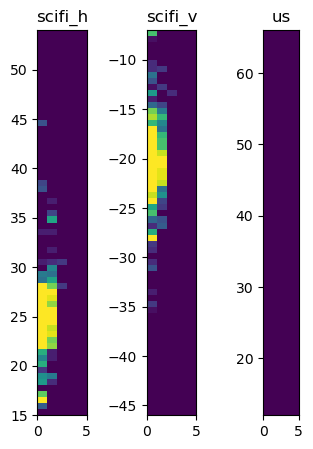

In [32]:
# n = np.random.randint(1000)
n = 145
print('n=',n)
fig, ax = plt.subplots(1, 3, figsize=(4,5))

hit_scifi = np.zeros((nplane['scifi'], 64, 2), dtype=int)
tmp_scifi = hit_wall['scifi_h'][0]['ve'][n,...,0]
for i in range(64): #12
    hit_scifi[:, i, 0] = tmp_scifi[:, 24*i:24*(i+1)].sum(axis=1) #128
tmp_scifi = hit_wall['scifi_v'][0]['ve'][n,...,0]
for i in range(64):
    hit_scifi[:, i, 1] = tmp_scifi[:, 24*i:24*(i+1)].sum(axis=1)
plt.imshow(hit_scifi[...,0].T)
for i, name in enumerate(['scifi_h', 'scifi_v', 'us']):
    if 'scifi' in name:
        ax[i].imshow(hit_scifi[...,i].T, origin='lower', extent=imextent[name])
    else:
        ax[i].imshow(hit_wall['us'][0]['ve'][n,...,0].T, extent=imextent['us_h'])
    ax[i].set_title(name)
    # cbar = fig.colorbar(im, ax=ax[i])
plt.show()

n= 145


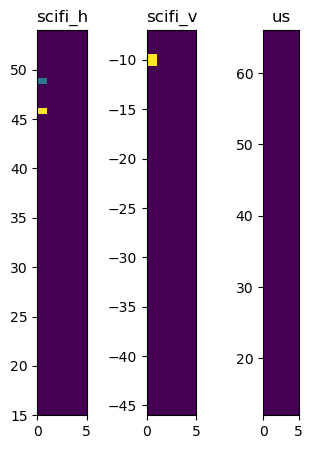

In [321]:
# n = np.random.randint(1000)
n = 145
print('n=',n)
fig, ax = plt.subplots(1, 3, figsize=(4,5))

hit_scifi = np.zeros((nplane['scifi'], 64, 2), dtype=int)
tmp_scifi = hit_wall['scifi_h'][0]['ve'][n,...,0]
for i in range(64): #12
    hit_scifi[:, i, 0] = tmp_scifi[:, 24*i:24*(i+1)].sum(axis=1) #128
tmp_scifi = hit_wall['scifi_v'][0]['ve'][n,...,0]
for i in range(64):
    hit_scifi[:, i, 1] = tmp_scifi[:, 24*i:24*(i+1)].sum(axis=1)
plt.imshow(hit_scifi[...,0].T)
for i, name in enumerate(['scifi_h', 'scifi_v', 'us']):
    if 'scifi' in name:
        ax[i].imshow(hit_scifi[...,i].T, origin='lower', extent=imextent[name])
    else:
        ax[i].imshow(hit_wall['us'][0]['ve'][n,...,0].T, extent=imextent['us_h'])
    ax[i].set_title(name)
    # cbar = fig.colorbar(im, ax=ax[i])
plt.show()

n= 178


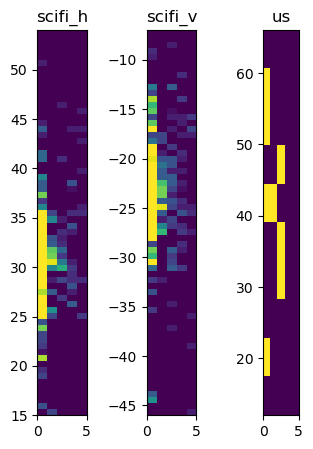

In [33]:
# n = np.random.randint(1000)
n = 178
print('n=',n)
fig, ax = plt.subplots(1, 3, figsize=(4,5))

hit_scifi = np.zeros((nplane['scifi'], 64, 2), dtype=int)
tmp_scifi = hit_wall['scifi_h'][0]['ve'][n,...,0]
for i in range(64): #12
    hit_scifi[:, i, 0] = tmp_scifi[:, 24*i:24*(i+1)].sum(axis=1) #128
tmp_scifi = hit_wall['scifi_v'][0]['ve'][n,...,0]
for i in range(64):
    hit_scifi[:, i, 1] = tmp_scifi[:, 24*i:24*(i+1)].sum(axis=1)
plt.imshow(hit_scifi[...,0].T)
for i, name in enumerate(['scifi_h', 'scifi_v', 'us']):
    if 'scifi' in name:
        ax[i].imshow(hit_scifi[...,i].T, origin='lower', extent=imextent[name])
    else:
        ax[i].imshow(hit_wall['us'][0]['ve'][n,...,0].T, extent=imextent['us_h'])
    ax[i].set_title(name)
    # cbar = fig.colorbar(im, ax=ax[i])
plt.show()

n= 178


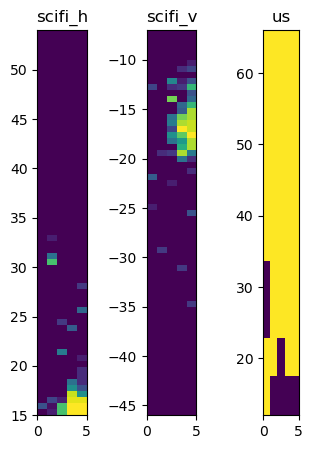

In [250]:
# n = np.random.randint(1000)
n = 178
print('n=',n)
fig, ax = plt.subplots(1, 3, figsize=(4,5))

hit_scifi = np.zeros((nplane['scifi'], 64, 2), dtype=int)
tmp_scifi = hit_wall['scifi_h'][0]['ve'][n,...,0]
for i in range(64): #12
    hit_scifi[:, i, 0] = tmp_scifi[:, 24*i:24*(i+1)].sum(axis=1) #128
tmp_scifi = hit_wall['scifi_v'][0]['ve'][n,...,0]
for i in range(64):
    hit_scifi[:, i, 1] = tmp_scifi[:, 24*i:24*(i+1)].sum(axis=1)
plt.imshow(hit_scifi[...,0].T)
for i, name in enumerate(['scifi_h', 'scifi_v', 'us']):
    if 'scifi' in name:
        ax[i].imshow(hit_scifi[...,i].T, origin='lower', extent=imextent[name])
    else:
        ax[i].imshow(hit_wall['us'][0]['ve'][n,...,0].T, extent=imextent['us_h'])
    ax[i].set_title(name)
    # cbar = fig.colorbar(im, ax=ax[i])
plt.show()

### Visualise aggregated distributions

In [34]:
def plot_5walls(hit_wall, class_names=None, name='scifi'):
    ### Structure: hitwall[det_name][wall][class]
    ## event_map_w = event_map * (event_meta[:,0]>wall_coords[i_wall]) * (event_meta[:,0]<wall_coords[i_wall+1])
    if class_names is None: class_names = ['ve', 'vm', 'nc']
    for i_wall in range(nplane['scifi']):
        
        i_ax = 0
        hit_tot = {}
        for i_cl, cl_name in enumerate(class_names):
            if name=='scifi':
                tmp_scifi = np.zeros((nplane['scifi'], 64, 2))
                hit_tot[cl_name] = np.sum(hit_wall['scifi_h'][i_wall][cl_name], axis=0, dtype=int)
                for i in range(64):
                    tmp_scifi[:, i, 0] = hit_tot[cl_name][:, 24*i:24*(i+1), 0].sum(axis=1)
                hit_tot[cl_name] = np.sum(hit_wall['scifi_v'][i_wall][cl_name], axis=0, dtype=int)
                for i in range(64):
                    tmp_scifi[:, i, 1] = hit_tot[cl_name][:, 24*i:24*(i+1), 0].sum(axis=1)
                hit_tot[cl_name] = tmp_scifi
            else:
                hit_tot[cl_name] = np.sum(hit_wall[name][i_wall][cl_name], axis=0, dtype=int)
        fig, ax = plt.subplots(1, 6 if name!='us' else 3, figsize=(8 if name!='us' else 4,5))
        for vert in range(2):
            if name=='us' and vert: continue
            for i_cl, cl_name in enumerate(class_names):
                im = ax[i_cl+vert*3].imshow(hit_tot[cl_name][...,vert].T, origin='lower', extent=imextent[name+'_'+('v' if vert else 'h')])
                ax[i_cl+vert*3].set_title(cl_name+' '+('vert' if vert else 'horiz'))
                # cbar = fig.colorbar(im, ax=ax[i_cl+vert*3])
                i_ax += 1
        plt.suptitle(str(i_wall)+'wall '+name)
        plt.show()

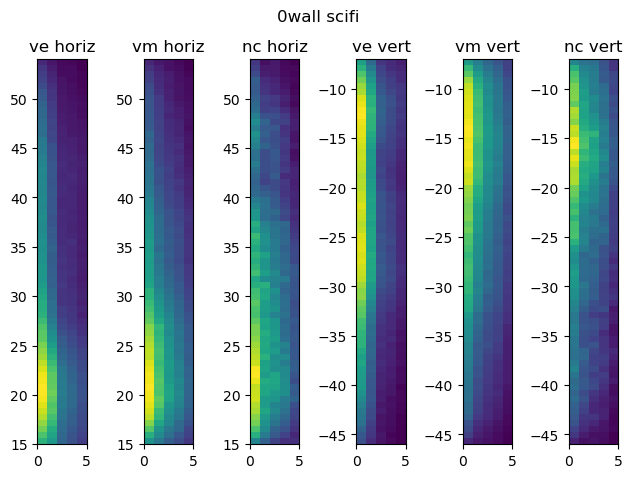

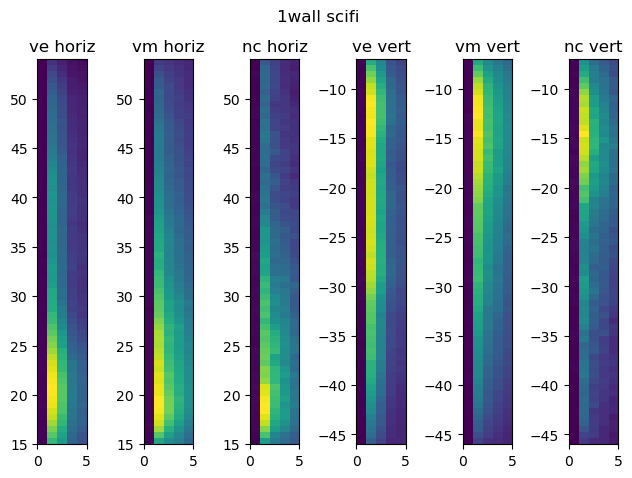

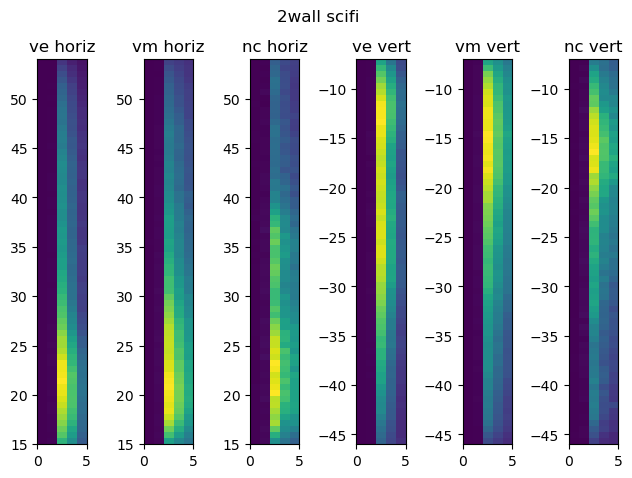

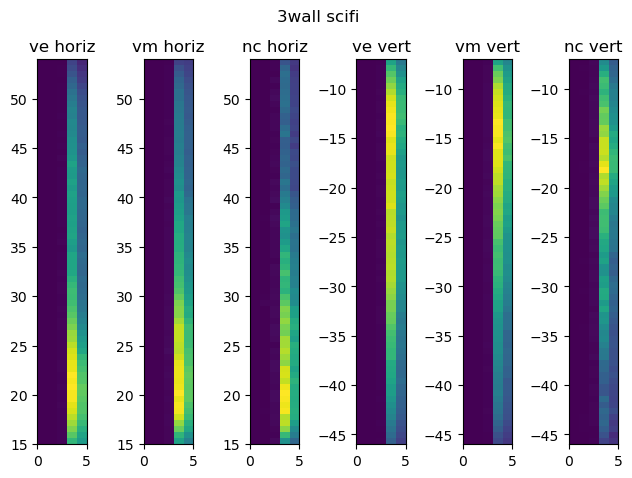

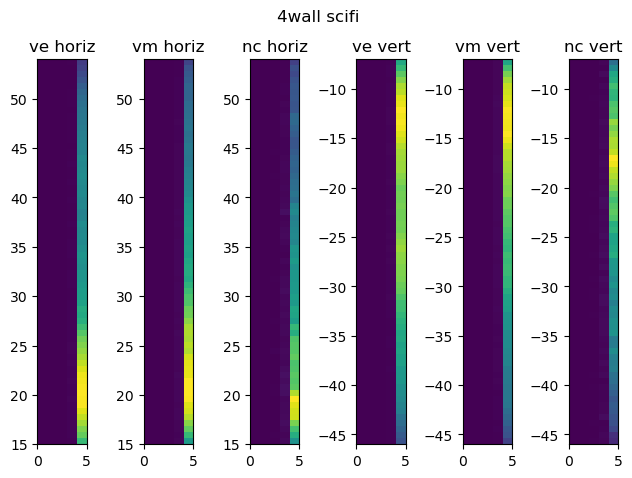

In [35]:
plot_5walls(hit_wall, class_names, name='scifi')

### Event distributions

In [36]:
from scipy.stats import norm
from scipy.optimize import curve_fit

In [37]:
# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def fit_gaus1d(hitmap, i_wall=0, name=None):
    hits1d = hitmap[i_wall:i_wall+2].sum(axis=0)
    mu, std = norm.fit(hits1d)
    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    if name is None: p0 = [30., 30., 10.]
    else:
        p0 = [30., 10., 10.] if name.endswith('h') else [30., 50., 10.]
    coeff, var_matrix = curve_fit(gauss, np.arange(len(hits1d)), hits1d, p0=p0, bounds=(0, np.inf))
    return coeff    

In [38]:
mu_wall = {nu_name:{} for nu_name in ['ve', 'vm', 'nc']}
std_wall = {nu_name:{} for nu_name in ['ve', 'vm', 'nc']}

2146it [00:17, 124.65it/s]
2180it [00:17, 126.40it/s]
2074it [00:15, 131.90it/s]
2100it [00:15, 133.78it/s]
1957it [00:15, 123.02it/s]


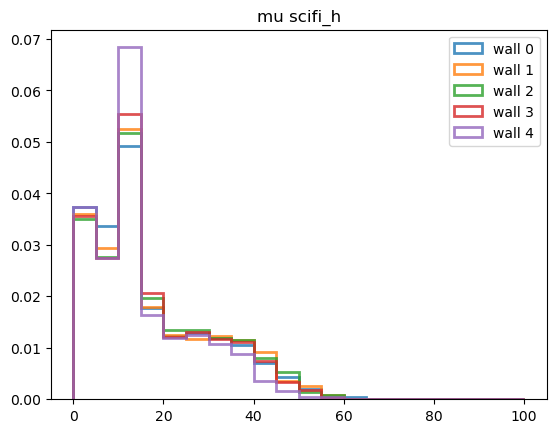

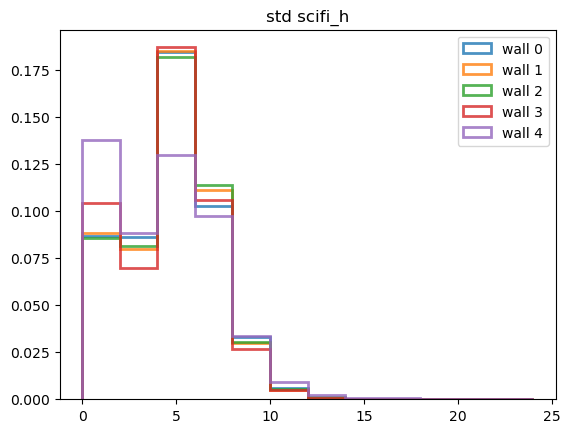

2146it [00:18, 118.46it/s]
2180it [00:19, 112.34it/s]
2074it [00:16, 122.62it/s]
2100it [00:17, 120.46it/s]
1957it [00:16, 120.71it/s]


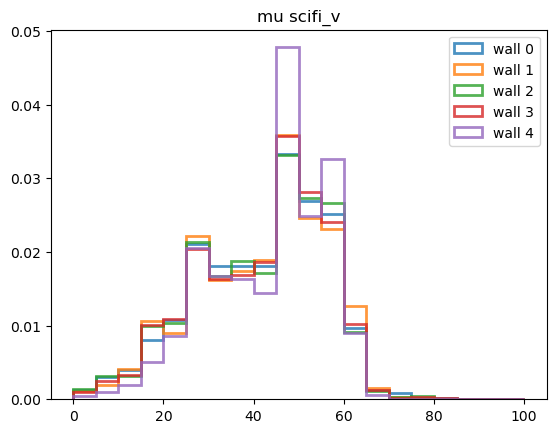

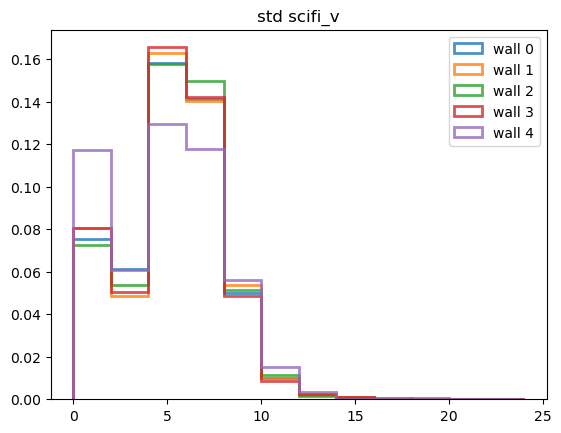

div_n: 118


In [39]:
nu_name = 've'
div_events = ''
for name in ['scifi_h', 'scifi_v']:
    mu_wall[nu_name][name] = [[] for i in range(n_wall)]
    std_wall[nu_name][name] = [[] for i in range(n_wall)]
    for i_wall in range(n_wall):
        n_scifi = hit_wall[name][i_wall][nu_name].shape[0]
        hit_scifi = np.zeros((n_scifi, nplane['scifi'], 64), dtype=int)
        tmp_scifi = hit_wall[name][i_wall][nu_name][..., 0]
        for i in range(64): #12
            hit_scifi[:, :, i] = tmp_scifi[:, :, 24*i:24*(i+1)].sum(axis=2) #128
        
        for i_ev, hit_ev in tqdm(enumerate(hit_scifi)):
            try:
                coeff = fit_gaus1d(hit_ev, i_wall, name)
                mu_wall[nu_name][name][i_wall].append(coeff[1])
                std_wall[nu_name][name][i_wall].append(coeff[2])
                if coeff[2]<0:
                    print('neg std. ', i_ev, ' mean:', np.around(coeff[1]), ' std:', np.around(coeff[2]))
            except:
                div_events+= name+', '+str(i_wall)+'wall, '+str(i_ev)+'\n'
    for i_wall in range(n_wall):
        plt.hist(mu_wall[nu_name][name][i_wall], bins=20, range=(0,100), label='wall '+str(i_wall), alpha=0.8, density=True, histtype='step', linewidth=2)
    plt.title('mu '+name)
    plt.legend()
    plt.show()
    for i_wall in range(n_wall):
        plt.hist(std_wall[nu_name][name][i_wall], bins=12, range=(0,24), label='wall '+str(i_wall), alpha=0.8, density=True, histtype='step', linewidth=2)
    plt.title('std '+name)
    plt.legend()
    plt.show()
print('div_n:',len(div_events.split('\n'))-1)

2146it [00:16, 133.61it/s]
2180it [00:17, 127.70it/s]
2074it [00:15, 133.01it/s]
2100it [00:15, 134.80it/s]
1957it [00:15, 123.98it/s]


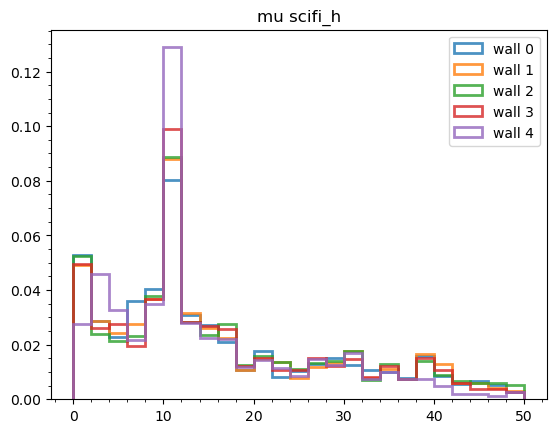

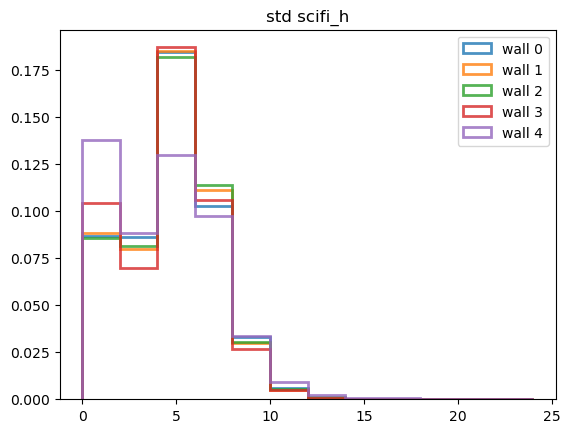

2146it [00:18, 118.34it/s]
2180it [00:19, 111.82it/s]
2074it [00:16, 122.55it/s]
2100it [00:17, 120.58it/s]
1957it [00:16, 119.73it/s]


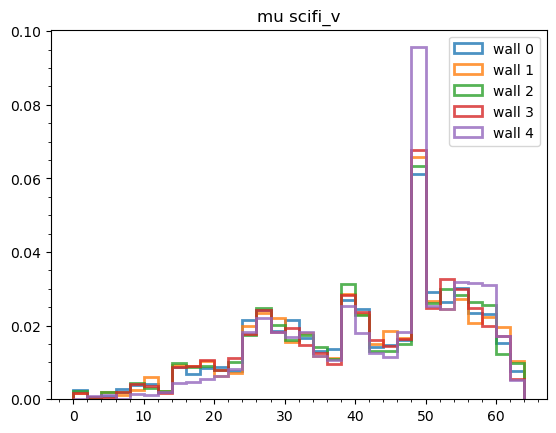

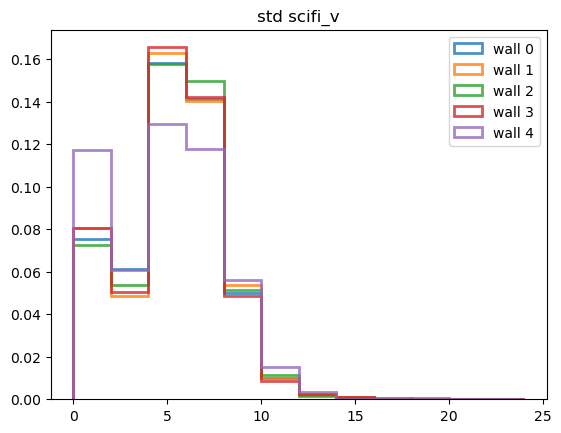

div_n: 118


In [40]:
nu_name = 've'
div_events = ''
for name in ['scifi_h', 'scifi_v']:
    mu_wall[nu_name][name] = [[] for i in range(n_wall)]
    std_wall[nu_name][name] = [[] for i in range(n_wall)]
    for i_wall in range(n_wall):
        n_scifi = hit_wall[name][i_wall][nu_name].shape[0]
        hit_scifi = np.zeros((n_scifi, nplane['scifi'], 64), dtype=int)
        tmp_scifi = hit_wall[name][i_wall][nu_name][..., 0]
        for i in range(64): #12
            hit_scifi[:, :, i] = tmp_scifi[:, :, 24*i:24*(i+1)].sum(axis=2) #128
        
        for i_ev, hit_ev in tqdm(enumerate(hit_scifi)):
            try:
                coeff = fit_gaus1d(hit_ev, i_wall, name)
                mu_wall[nu_name][name][i_wall].append(coeff[1])
                std_wall[nu_name][name][i_wall].append(coeff[2])
                if coeff[2]<0:
                    print('neg std. ', i_ev, ' mean:', np.around(coeff[1]), ' std:', np.around(coeff[2]))
            except:
                div_events+= name+', '+str(i_wall)+'wall, '+str(i_ev)+'\n'
    for i_wall in range(n_wall):
        plt.hist(mu_wall[nu_name][name][i_wall], bins=25 if 'h' in name else 32, range=(0,50 if 'h' in name else 64), label='wall '+str(i_wall), alpha=0.8, density=True, histtype='step', linewidth=2)
    plt.title('mu '+name)
    plt.legend()
    plt.minorticks_on()
    plt.show()
    for i_wall in range(n_wall):
        plt.hist(std_wall[nu_name][name][i_wall], bins=12, range=(0,24), label='wall '+str(i_wall), alpha=0.8, density=True, histtype='step', linewidth=2)
    plt.title('std '+name)
    plt.legend()
    plt.show()
print('div_n:',len(div_events.split('\n'))-1)

6525it [01:10, 92.78it/s] 
6575it [01:11, 92.20it/s] 
6551it [01:06, 98.44it/s] 
6515it [01:10, 93.07it/s] 
6719it [01:28, 76.12it/s] 


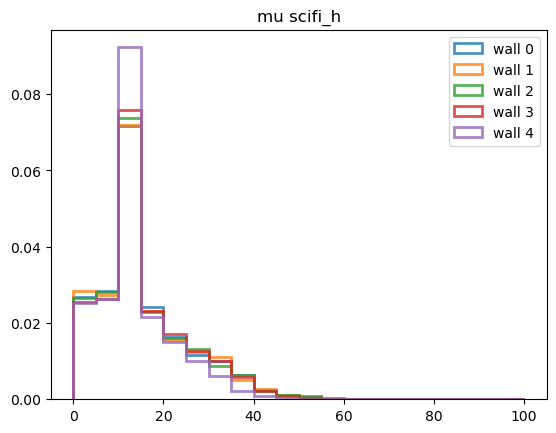

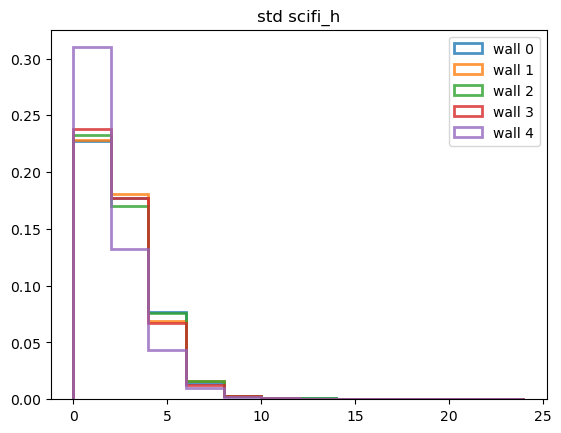

6525it [01:20, 81.13it/s] 
6575it [01:23, 78.46it/s] 
6551it [01:23, 78.04it/s] 
6515it [01:24, 77.24it/s] 
6719it [01:28, 76.20it/s] 


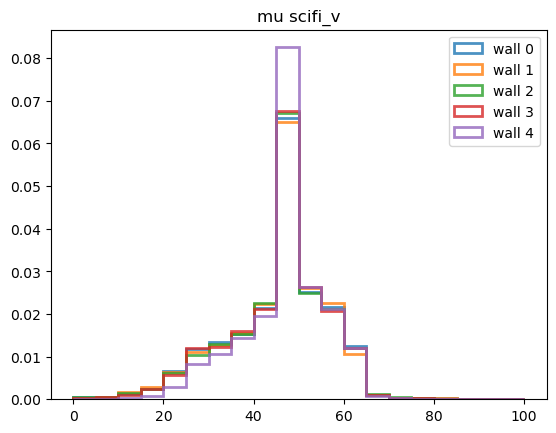

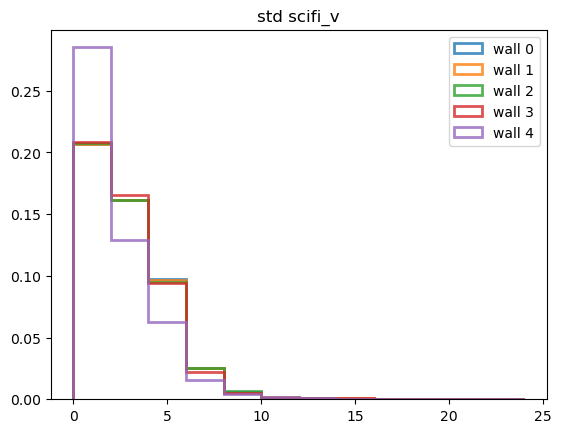

div_n: 1029


In [41]:
nu_name = 'vm'
div_events = ''
for name in ['scifi_h', 'scifi_v']:
    mu_wall[nu_name][name] = [[] for i in range(n_wall)]
    std_wall[nu_name][name] = [[] for i in range(n_wall)]
    for i_wall in range(n_wall):
        n_scifi = hit_wall[name][i_wall][nu_name].shape[0]
        hit_scifi = np.zeros((n_scifi, nplane['scifi'], 64), dtype=int)
        tmp_scifi = hit_wall[name][i_wall][nu_name][..., 0]
        for i in range(64): #12
            hit_scifi[:, :, i] = tmp_scifi[:, :, 24*i:24*(i+1)].sum(axis=2) #128
        
        for i_ev, hit_ev in tqdm(enumerate(hit_scifi)):
            try:
                coeff = fit_gaus1d(hit_ev, i_wall, name)
                mu_wall[nu_name][name][i_wall].append(coeff[1])
                std_wall[nu_name][name][i_wall].append(coeff[2])
                if coeff[2]<0:
                    print('neg std. ', i_ev, ' mean:', np.around(coeff[1]), ' std:', np.around(coeff[2]))
            except:
                div_events+= name+', '+str(i_wall)+'wall, '+str(i_ev)+'\n'
    for i_wall in range(n_wall):
        plt.hist(mu_wall[nu_name][name][i_wall], bins=20, range=(0,100), label='wall '+str(i_wall), alpha=0.8, density=True, histtype='step', linewidth=2)
    plt.title('mu '+name)
    plt.legend()
    plt.show()
    for i_wall in range(n_wall):
        plt.hist(std_wall[nu_name][name][i_wall], bins=12, range=(0,24), label='wall '+str(i_wall), alpha=0.8, density=True, histtype='step', linewidth=2)
    plt.title('std '+name)
    plt.legend()
    plt.show()
print('div_n:',len(div_events.split('\n'))-1)

1518it [00:15, 97.64it/s] 
1558it [00:18, 85.28it/s] 
1633it [00:18, 89.67it/s] 
1555it [00:17, 89.05it/s] 
1353it [00:20, 64.62it/s]


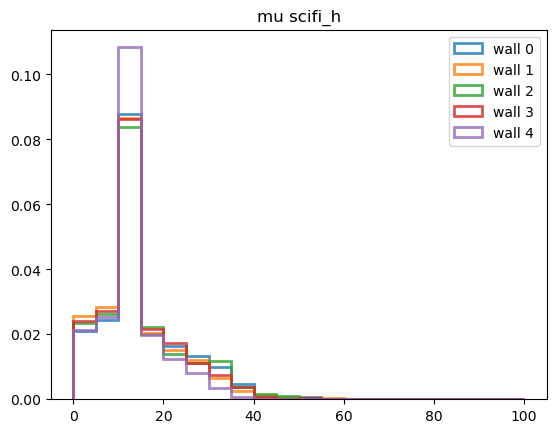

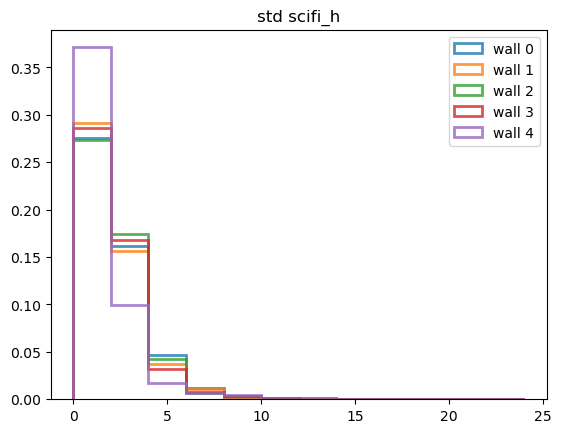

1518it [00:19, 76.48it/s] 
1558it [00:20, 76.03it/s] 
1633it [00:22, 71.62it/s] 
1555it [00:21, 72.42it/s] 
1353it [00:20, 65.10it/s]


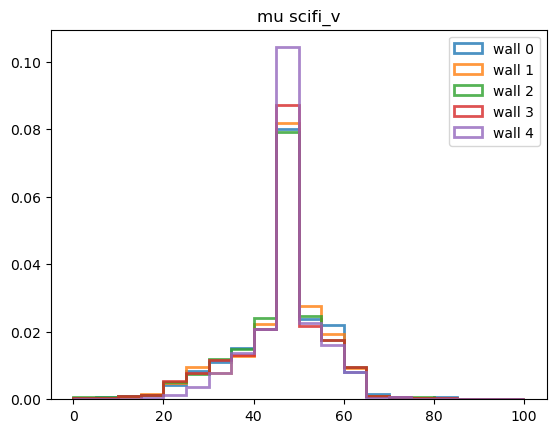

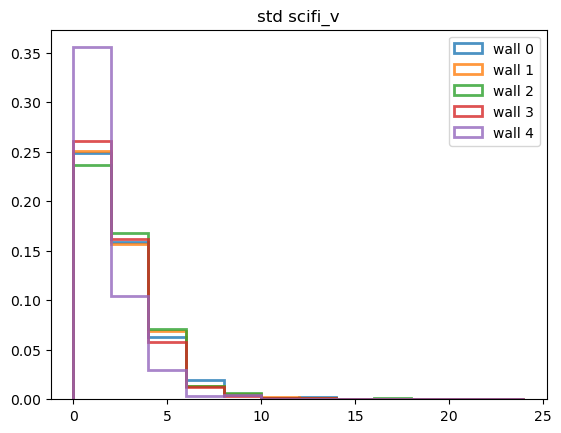

div_n: 268


In [42]:
nu_name = 'nc'
div_events = ''
for name in ['scifi_h', 'scifi_v']:
    mu_wall[nu_name][name] = [[] for i in range(n_wall)]
    std_wall[nu_name][name] = [[] for i in range(n_wall)]
    for i_wall in range(n_wall):
        n_scifi = hit_wall[name][i_wall][nu_name].shape[0]
        hit_scifi = np.zeros((n_scifi, nplane['scifi'], 64), dtype=int)
        tmp_scifi = hit_wall[name][i_wall][nu_name][..., 0]
        for i in range(64): #12
            hit_scifi[:, :, i] = tmp_scifi[:, :, 24*i:24*(i+1)].sum(axis=2) #128
        
        for i_ev, hit_ev in tqdm(enumerate(hit_scifi)):
            try:
                coeff = fit_gaus1d(hit_ev, i_wall, name)
                mu_wall[nu_name][name][i_wall].append(coeff[1])
                std_wall[nu_name][name][i_wall].append(coeff[2])
                if coeff[2]<0:
                    print('neg std. ', i_ev, ' mean:', np.around(coeff[1]), ' std:', np.around(coeff[2]))
            except:
                div_events+= name+', '+str(i_wall)+'wall, '+str(i_ev)+'\n'
    for i_wall in range(n_wall):
        plt.hist(mu_wall[nu_name][name][i_wall], bins=20, range=(0,100), label='wall '+str(i_wall), alpha=0.8, density=True, histtype='step', linewidth=2)
    plt.title('mu '+name)
    plt.legend()
    plt.show()
    for i_wall in range(n_wall):
        plt.hist(std_wall[nu_name][name][i_wall], bins=12, range=(0,24), label='wall '+str(i_wall), alpha=0.8, density=True, histtype='step', linewidth=2)
    plt.title('std '+name)
    plt.legend()
    plt.show()
print('div_n:',len(div_events.split('\n'))-1)

### STD filter separator

thr: 1.0	ve : 82.9 %	vm : 63.6 %	nc : 55.1 %	
thr: 1.5	ve : 82.3 %	vm : 59.1 %	nc : 50.1 %	
thr: 2.0	ve : 81.5 %	vm : 52.9 %	nc : 43.6 %	
thr: 2.5	ve : 80.0 %	vm : 45.0 %	nc : 35.2 %	
thr: 3.0	ve : 77.5 %	vm : 36.3 %	nc : 26.3 %	
thr: 3.5	ve : 73.7 %	vm : 27.9 %	nc : 18.8 %	
thr: 4.0	ve : 67.9 %	vm : 20.7 %	nc : 13.1 %	
thr: 4.5	ve : 60.7 %	vm : 14.8 %	nc : 9.3 %	
thr: 5.0	ve : 52.2 %	vm : 10.4 %	nc : 6.4 %	
thr: 5.5	ve : 43.6 %	vm : 7.3 %	nc : 4.7 %	
thr: 6.0	ve : 35.0 %	vm : 5.1 %	nc : 3.6 %	
thr: 6.5	ve : 27.1 %	vm : 3.6 %	nc : 2.7 %	
thr: 7.0	ve : 20.5 %	vm : 2.6 %	nc : 2.1 %	
thr: 7.5	ve : 14.9 %	vm : 2.0 %	nc : 1.7 %	
thr: 8.0	ve : 10.5 %	vm : 1.5 %	nc : 1.5 %	
thr: 8.5	ve : 7.4 %	vm : 1.2 %	nc : 1.2 %	
thr: 9.0	ve : 4.9 %	vm : 1.0 %	nc : 1.0 %	
thr: 9.5	ve : 3.3 %	vm : 0.8 %	nc : 0.8 %	


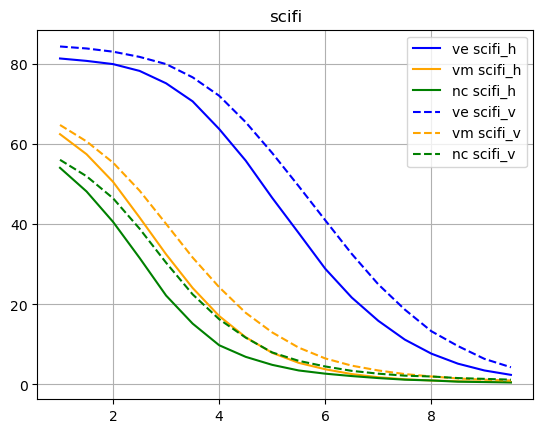

In [43]:
# std_thresh = 4
std_thr_range = np.arange(1,10, 0.5)
thr_perc = {nu_name:{name:[] for name in ['scifi_h', 'scifi_v']} for nu_name in ['ve', 'vm', 'nc']}
for std_thresh in std_thr_range:
    print('thr:', std_thresh, end='\t')
    for nu_name in ['ve', 'vm', 'nc']:
        n_tot, n_thr = 0, 0
        for name in ['scifi_h', 'scifi_v']:
            n_tot_name, n_thr_name = 0, 0
            for i_wall in range(5):
                n_tot_name += len(std_wall[nu_name][name][i_wall])
                n_thr_name += np.sum(np.array(std_wall[nu_name][name][i_wall])>std_thresh)
            n_tot += n_tot_name
            n_thr += n_thr_name
            thr_perc[nu_name][name].append(np.around(n_thr_name/n_tot_name*100, decimals=1))
        print(nu_name, ':', np.around(n_thr/n_tot*100, decimals=1), '%', end='\t')
    print()

plt.plot(std_thr_range, thr_perc['ve']['scifi_h'], 'blue', label='ve '+'scifi_h')
plt.plot(std_thr_range, thr_perc['vm']['scifi_h'], 'orange', label='vm '+'scifi_h')
plt.plot(std_thr_range, thr_perc['nc']['scifi_h'], 'green', label='nc '+'scifi_h')

plt.plot(std_thr_range, thr_perc['ve']['scifi_v'], 'blue', ls='dashed', label='ve '+'scifi_v')
plt.plot(std_thr_range, thr_perc['vm']['scifi_v'], 'orange', ls='dashed', label='vm '+'scifi_v')
plt.plot(std_thr_range, thr_perc['nc']['scifi_v'], 'green', ls='dashed', label='nc '+'scifi_v')
plt.title('scifi')
plt.grid()
plt.legend()
plt.show()

### Confusion matrix with variable threshold for Ve

* we try to enforce higher purity for Ve by requiring minimal threshold on algorithm's "confidence"

In [44]:
def ve_thresh(y_pred, thresh=0.7):
    ve_mask = (y_pred[:,0]>thresh) * (np.argmax(y_pred, axis=-1)==0)
    nonve_mask = np.invert(ve_mask)
    preds = np.zeros(y_pred.shape[0])
    preds[nonve_mask] = np.argmax(y_pred[nonve_mask,1:], axis=-1)+1
    return preds

* confusion matrix

In [45]:
confusion_matrix(test_lab, ve_thresh(test_pred[0], thresh=0.7))

array([[57.2,  7.9, 34.9],
       [ 2.1, 91.7,  6.2],
       [13.4, 10.1, 76.5]])

In [46]:
confusion_matrix(test_lab, ve_thresh(test_pred[0], thresh=0.8))

array([[49.7,  9. , 41.4],
       [ 1.4, 92.1,  6.5],
       [ 9.5, 10.6, 80. ]])

In [47]:
confusion_matrix(test_lab, ve_thresh(test_pred[0], thresh=0.87))

array([[42.7,  9.8, 47.5],
       [ 0.9, 92.3,  6.8],
       [ 6.5, 11. , 82.6]])

* purity matrix

In [48]:
confusion_purity_matrix(test_lab, ve_thresh(test_pred[0], thresh=0.7))

array([[78.1,  3.2, 31. ],
       [ 7.1, 93.4, 13.6],
       [14.8,  3.4, 55.3]])

In [49]:
confusion_purity_matrix(test_lab, ve_thresh(test_pred[0], thresh=0.8))

array([[81.8,  3.6, 33.8],
       [ 5.5, 92.9, 13.2],
       [12.7,  3.5, 53. ]])

In [50]:
confusion_purity_matrix(test_lab, ve_thresh(test_pred[0], thresh=0.87))

array([[85.1,  3.9, 36.2],
       [ 4.4, 92.5, 12.8],
       [10.5,  3.6, 51. ]])

# Expected gradients - relevance map visualisation